# Cross-validation framework

Go into details into the cross-validation framework.

Before we dive in, let's linger on the reasons for always having training and testing sets. Let's first look at the limitation of using a dataset without keeping any samples out.

To illustrate the different concepts, we will use the California housing
dataset.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In this dataset, the aim is to predict the median value of houses in an area
in California. The features collected are based on general real-estate and
geographical information.

In [2]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [3]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
target

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

To simplify future visualization, let's transform the prices from the
100 (k\\$) range to the thousand dollars (k\\$) range.

In [5]:
target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

## Training error vs testing error

To solve this regression task, we will use a decision tree regressor.

In [6]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=0)

After training the regressor, we would like to know its potential generalization performance once deployed in production. For this purpose, we use the mean absolute error, which gives us an error in the native unit, i.e. k\\$.

In [7]:
from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


We get perfect prediction with no error. It is too optimistic and almost
always revealing a methodological problem when doing machine learning.

Indeed, we trained and predicted on the same dataset. Since our decision tree
was fully grown, every sample in the dataset is stored in a leaf node.
Therefore, our decision tree fully memorized the dataset given during `fit`
and therefore made no error when predicting.

This error computed above is called the **empirical error** or **training
error**.

We trained a predictive model to minimize the training error but our aim is
to minimize the error on data that has not been seen during training.

This error is also called the **generalization error** or the "true"
**testing error**.

Thus, the most basic evaluation involves:

* splitting our dataset into two subsets: a training set and a testing set;
* fitting the model on the training set;
* estimating the training error on the training set;
* estimating the testing error on the testing set.

So let's split our dataset.

In [8]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)

Then, let's train our model.

In [9]:
regressor.fit(data_train, target_train)

DecisionTreeRegressor(random_state=0)

Finally, we estimate the different types of errors. Let's start by computing the training error.

In [10]:
target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of our model is {score:.2f} k$")

The training error of our model is 0.00 k$


We observe the same phenomena as in the previous experiment: our model memorized the training set. However, we now compute the testing error.

In [11]:
target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The testing error of our model is 47.28 k$


This testing error is actually about what we would expect from our model if it was used in a production environment.

## Stability of the cross-validation estimates

When doing a single train-test split we don't give any indication regarding
the robustness of the evaluation of our predictive model: in particular, if
the test set is small, this estimate of the testing error will be unstable and
wouldn't reflect the "true error rate" we would have observed with the same
model on an unlimited amount of test data.

For instance, we could have been lucky when we did our random split of our
limited dataset and isolated some of the easiest cases to predict in the
testing set just by chance: the estimation of the testing error would be
overly optimistic, in this case.

**Cross-validation** allows estimating the robustness of a predictive model by
repeating the splitting procedure. It will give several training and testing
errors and thus some **estimate of the variability of the model generalization
performance**.

There are [different cross-validation
strategies](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators),
for now we are going to focus on one called "shuffle-split". At each iteration
of this strategy we:

- randomly shuffle the order of the samples of a copy of the full dataset;
- split the shuffled dataset into a train and a test set;
- train a new model on the train set;
- evaluate the testing error on the test set.

We repeat this procedure `n_splits` times. Keep in mind that the computational
cost increases with `n_splits`.

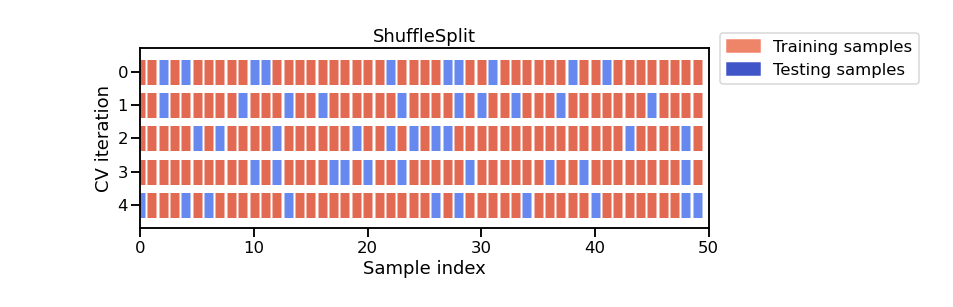

In this case we will set `n_splits=40`, meaning that we will train 40 models
in total and all of them will be discarded: we just record their
generalization performance on each variant of the test set.

In [12]:
from sklearn.model_selection import (
    cross_validate,
    ShuffleSplit
)

cv = ShuffleSplit(n_splits=40, test_size=.3, random_state=0)
cv_results = cross_validate(
    regressor, 
    data, 
    target, 
    cv=cv, 
    scoring='neg_mean_absolute_error'
)

In [13]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.244349,0.006374,-46.909797
1,0.207983,0.004382,-46.421170
2,0.162671,0.005467,-47.411089
3,0.175248,0.004385,-44.319824
4,0.172271,0.005316,-47.607875


A score is a metric for which higher values mean better results. On the contrary, an error is a metric for which lower values mean better results. The parameter scoring in cross_validate always expect a function that is a score.

To make it easy, all error metrics in scikit-learn, like mean_absolute_error, can be transformed into a score to be used in cross_validate. To do so, you need to pass a string of the error metric with an additional neg_ string at the front to the parameter scoring; for instance scoring="neg_mean_absolute_error". In this case, the negative of the mean absolute error will be computed which would be equivalent to a score.

Let us revert the negation to get the actual error:

In [14]:
cv_results['test_error'] = -cv_results['test_score']

Let's check the results reported by the cross-validation.

In [16]:
cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.244349,0.006374,-46.909797,46.909797
1,0.207983,0.004382,-46.421170,46.421170
2,0.162671,0.005467,-47.411089,47.411089
3,0.175248,0.004385,-44.319824,44.319824
4,0.172271,0.005316,-47.607875,47.607875
5,0.166171,0.004449,-45.901300,45.901300
6,0.166897,0.004436,-46.572767,46.572767
7,0.179103,0.004579,-46.194585,46.194585
8,0.167248,0.004305,-45.590236,45.590236
9,0.165279,0.004693,-45.727998,45.727998


We get 40 entries in our resulting dataframe because we performed 40 splits.
Therefore, we can show the testing error distribution and thus, have an
estimate of its variability.

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

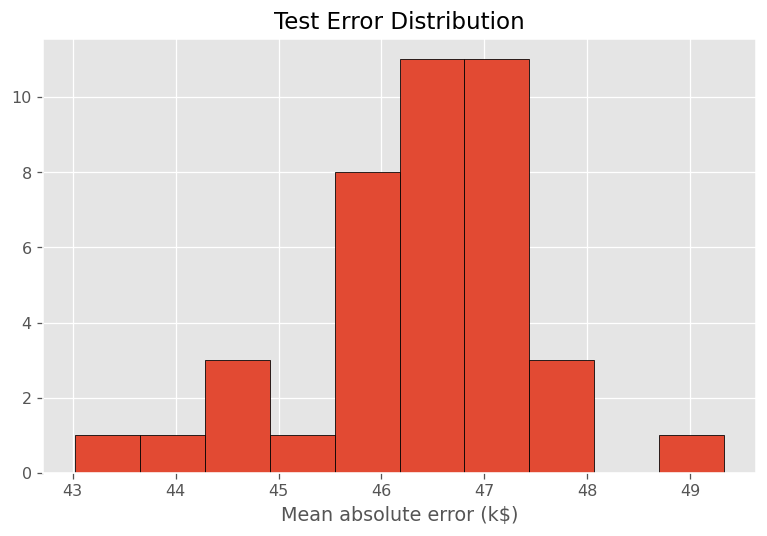

In [23]:
plt.figure(figsize=(8,5), dpi=115)
plt.hist(cv_results['test_error'],bins=10, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
plt.title('Test Error Distribution')
plt.show();

We observe that the testing error is clustered around 47 k\\$ and ranges from 43 k\\$ to 50 k\\$.

In [21]:
print(f"The mean cross-validated testing error is: "
      f"{cv_results['test_error'].mean():.2f} k$")

The mean cross-validated testing error is: 46.36 k$


In [22]:
print(f"The standard deviation of the testing error is: "
      f"{cv_results['test_error'].std():.2f} k$")

The standard deviation of the testing error is: 1.17 k$


Note that the standard deviation is much smaller than the mean: we could
summarize that our cross-validation estimate of the testing error is 46.36 +/-
1.17 k\\$.

If we were to train a single model on the full dataset (without
cross-validation) and then later had access to an unlimited amount of test
data, we would expect its true testing error to fall close to that region.

While this information is interesting in itself, it should be contrasted to
the scale of the natural variability of the vector `target` in our dataset.

Let us plot the distribution of the target variable:

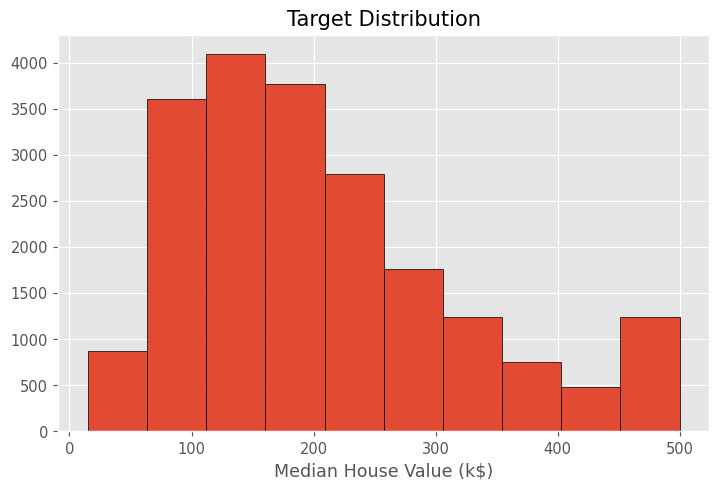

In [26]:
plt.figure(figsize=(8,5), dpi=105)
plt.hist(target,bins=10, edgecolor="black")
plt.xlabel("Median House Value (k$)")
plt.title('Target Distribution')
plt.show();

In [27]:
print(f"The standard deviation of the target is: {target.std():.2f} k$")

The standard deviation of the target is: 115.40 k$


The target variable ranges from close to 0 k\\$ up to 500 k\\$ and, with a
standard deviation around 115 k\\$.

We notice that the mean estimate of the testing error obtained by
cross-validation is a bit smaller than the natural scale of variation of the
target variable. Furthermore, the standard deviation of the cross validation
estimate of the testing error is even smaller.

This is a good start, but not necessarily enough to decide whether the
generalization performance is good enough to make our prediction useful in
practice.

We recall that our model makes, on average, an error around 47 k\\$. With this
information and looking at the target distribution, such an error might be
acceptable when predicting houses with a 500 k\\$. However, it would be an
issue with a house with a value of 50 k\\$. Thus, this indicates that our
metric (Mean Absolute Error) is not ideal.

We might instead choose a metric relative to the target value to predict: the
mean absolute percentage error would have been a much better choice.

But in all cases, an error of 47 k\\$ might be too large to automatically use
our model to tag house values without expert supervision.

## More detail regarding `cross_validate`

During cross-validation, many models are trained and evaluated. Indeed, the
number of elements in each array of the output of `cross_validate` is a
result from one of these `fit`/`score` procedures. To make it explicit, it is
possible to retrieve these fitted models for each of the splits/folds by
passing the option `return_estimator=True` in `cross_validate`.

In [28]:
cv_results = cross_validate(
    regressor, 
    data, 
    target,
    return_estimator=True
)

In [29]:
cv_results["estimator"]

[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0)]

## Summary

In this notebook, we saw:

* the necessity of splitting the data into a train and test set;
* the meaning of the training and testing errors;
* the overall cross-validation framework with the possibility to study
  generalization performance variations.

# Overfit-generalization-underfit

In the last, we presented the general cross-validation framework
and how it helps us quantify the training and testing errors as well
as their fluctuations.

Now, we will put these two errors into perspective and show how
they can help us know if our model generalizes, overfits, or underfits.

In [30]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [31]:
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

## Overfitting vs. underfitting

To better understand the generalization performance of our model and maybe find
insights on how to improve it, we will compare the testing error with the
training error. Thus, we need to compute the error on the training set,
which is possible using the `cross_validate` function.

In [32]:
regressor = DecisionTreeRegressor()
cv = ShuffleSplit(n_splits=30, test_size=.2, random_state=42)
cv_results = cross_validate(
    regressor,
    data,
    target,
    cv=cv,
    return_train_score=True,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
)

In [34]:
cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score,train_score
0,0.311676,0.005525,-45.376421,-3.700743e-15
1,0.306863,0.005557,-45.746454,-1.338120e-14
2,0.323501,0.005992,-45.987638,-3.370258e-15
3,0.298110,0.005310,-47.324123,-1.340874e-14
4,0.304668,0.005150,-45.286040,-3.521731e-15


In [35]:
cv_results = (
    cv_results.assign(
        test_error = -cv_results.test_score,
        train_error = -cv_results.train_score,
    )
)

cv_results.head()

,fit_time,score_time,test_score,train_score,test_error,train_error
0,0.311676,0.005525,-45.376421,-3.700743e-15,45.376421,3.700743e-15
1,0.306863,0.005557,-45.746454,-1.338120e-14,45.746454,1.338120e-14
2,0.323501,0.005992,-45.987638,-3.370258e-15,45.987638,3.370258e-15
3,0.298110,0.005310,-47.324123,-1.340874e-14,47.324123,1.340874e-14
4,0.304668,0.005150,-45.286040,-3.521731e-15,45.286040,3.521731e-15


In [36]:
scores = cv_results[['test_error', 'train_error']].copy()
scores.head()

,test_error,train_error
0,45.376421,3.700743e-15
1,45.746454,1.338120e-14
2,45.987638,3.370258e-15
3,47.324123,1.340874e-14
4,45.286040,3.521731e-15


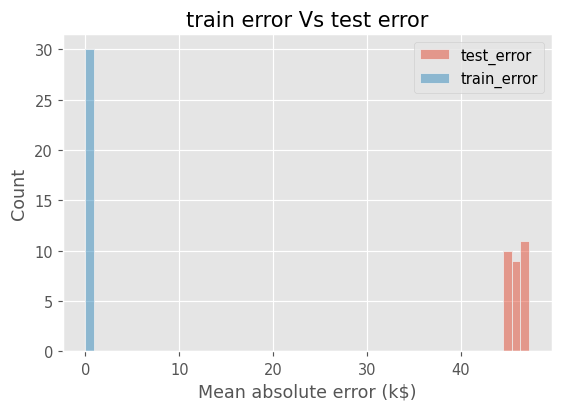

In [42]:
import seaborn as sns

plt.figure(figsize=(6, 4), dpi=105)
sns.histplot(scores, bins=50)
plt.xlabel('Mean absolute error (k$)')
plt.title('train error Vs test error')
# plt.hist(scores, bins=50, edgecolor='black')
plt.show();

By plotting the distribution of the training and testing errors, we
get information about whether our model is over-fitting, under-fitting (or
both at the same time).

Here, we observe a **small training error** (actually zero), meaning that
the model is **not under-fitting**: it is flexible enough to capture any
variations present in the training set.

However the **significantly larger testing error** tells us that the
model is **over-fitting**: the model has memorized many variations of the
training set that could be considered "noisy" because they do not generalize
to help us make good prediction on the test set.

## Validation curve

Some model hyperparameters are usually the key to go from a model that
underfits to a model that overfits, hopefully going through a region were we
can get a good balance between the two. We can acquire knowledge by plotting
a curve called the validation curve. This curve can also be applied to the
above experiment and varies the value of a hyperparameter.

For the decision tree, the `max_depth` parameter is used to control the
tradeoff between under-fitting and over-fitting.

In [53]:
from sklearn.model_selection import validation_curve

max_depth = list(range(1, 30, 5))

train_scores, test_scores = validation_curve(
    regressor,
    data,
    target,
    cv=cv,
    scoring='neg_mean_absolute_error',
    param_name='max_depth',
    param_range=max_depth,
    n_jobs=-1
)

In [54]:
test_errors, train_errors = -test_scores, -train_scores

Now that we collected the results, we will show the validation curve by
plotting the training and testing errors (as well as their deviations).

In [47]:
test_errors.shape

(6, 30)

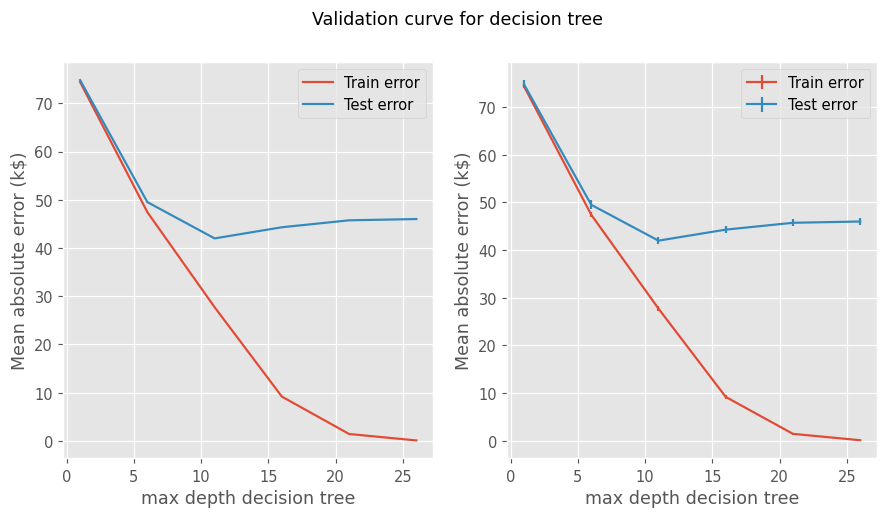

In [57]:
plt.figure(figsize=(10, 5), dpi=105)

plt.subplot(1, 2, 1)
plt.plot(max_depth, train_errors.mean(axis=1), label='Train error')
plt.plot(max_depth, test_errors.mean(axis=1), label='Test error')
plt.xlabel('max depth decision tree')
plt.ylabel('Mean absolute error (k$)')
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(
    max_depth, 
    train_errors.mean(axis=1), 
    yerr=train_errors.std(axis=1), 
    label='Train error')

plt.errorbar(
    max_depth, 
    test_errors.mean(axis=1), 
    yerr=test_errors.std(axis=1), 
    label='Test error')

plt.xlabel('max depth decision tree')
plt.ylabel('Mean absolute error (k$)')
plt.legend()

plt.suptitle('Validation curve for decision tree')
plt.show();

The validation curve can be divided into three areas:

- For `max_depth < 11`, the decision tree underfits. The training error and
  therefore the testing error are both high. The model is too
  constrained and cannot capture much of the variability of the target
  variable.

- The region around `max_depth = 11` corresponds to the parameter for which
  the decision tree generalizes the best. It is flexible enough to capture a
  fraction of the variability of the target that generalizes, while not
  memorizing all of the noise in the target.

- For `max_depth > 11`, the decision tree overfits. The training error
  becomes very small, while the testing error increases. In this
  region, the models create decisions specifically for noisy samples harming
  its ability to generalize to test data.

Note that for `max_depth = 11`, the model overfits a bit as there is a gap
between the training error and the testing error. It can also
potentially underfit also a bit at the same time, because the training error
is still far from zero (more than 30 k\\$), meaning that the model might
still be too constrained to model interesting parts of the data. However, the
testing error is minimal, and this is what really matters. This is the
best compromise we could reach by just tuning this parameter.

Be aware that looking at the mean errors is quite limiting. We should also
look at the standard deviation to assess the dispersion of the score. We
can repeat the same plot as before but this time, we will add some
information to show the standard deviation of the errors as well.